In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import struct
import functions as datahelper
from matplotlib import pyplot as plt
%matplotlib inline 

In [12]:
tf.reset_default_graph()

# hyperparameters -- TODO save in config file
batch_size=32
z_dim = 100 # random noise vector dimension 

beta1=0.5 # β1 Adam training param
learning_rate = 0.0002
lmda = 0.003 # λ ratio for prior loss

epochs = 5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

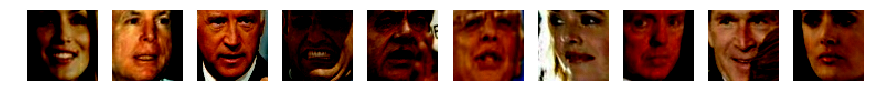

In [24]:
# data TODO
image_shape = (64, 64, 3)

generator_input = tf.placeholder(tf.float32, shape=(batch_size, z_dim)) # vec from uniform distr. [-1, 1]
# discriminator_input = tf.placeholder(tf.float32, shape=(batch_size*2, 64, 64, 3))

mask = tf.placeholder(tf.float32, shape=image_shape)


dataset = tf.data.TFRecordDataset(filenames="./data/data.tfrecord")
dataset  = dataset.map(datahelper.extract_fn)

# dataset = tf.data.TFRecordDataset.from_tensor_slices(dataset)
dataset = dataset.shuffle(buffer_size=300)
dataset = dataset.batch(batch_size)


iterator = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)
init_op = iterator.make_initializer(dataset)

# batched data to feed in
image_data = iterator.get_next()
image_data = tf.cast((image_data/255)*2  - 1, dtype=tf.float32)

# visualize original data
with tf.Session() as sess:
    sess.run(init_op)
    img = np.array(sess.run(image_data))
    fig, ax = plt.subplots(1,10,figsize=(15,15))
    for i in range(10):
        _img = img[i,:,:,:]
        ax[i].imshow(_img)
        ax[i].axis('off')


In [4]:
# layer functions
def feed_forward_layer(name, x, hidden_n, activation_fn, normalize, stddev=0.02, weight_params = None, bias_params = None):
        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
            initializer = tf.random_normal_initializer(stddev)
            
            if weight_params is not None:
                weights = tf.Variable(weight_params, name='weights', dtype=tf.float32)
            else: 
                weights = tf.get_variable("weights", [x.shape[1], hidden_n], tf.float32, initializer)
            
            if bias_params is not None:
                biases = tf.Variable(bias_params, name='biases', dtype=tf.float32)
            else:
                biases = tf.get_variable("biases", [hidden_n], tf.float32, tf.zeros_initializer())

            drive = tf.matmul(x, weights) + biases
            if normalize:
                drive = batch_norm(drive, [0])

            return activation_fn(drive)


def conv_layer(name, x, kernels_n, kernel_size, stride_size, activation_fn, normalize, stddev=0.02):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        initializer = tf.random_normal_initializer(stddev)
        kernels = tf.get_variable("kernels", [kernel_size, kernel_size, x.shape[-1], kernels_n], tf.float32, initializer)
        biases = tf.get_variable("biases", [kernels_n], tf.float32, tf.zeros_initializer())

        drive = tf.nn.conv2d(x, kernels, strides = [1, stride_size, stride_size, 1], padding = "SAME") + biases
        if normalize:
            drive = batch_norm(drive, [0,1,2])
    
        return activation_fn(drive)


def deconv_layer(name, x, target_shape, kernel_size, stride_size, activation_fn, normalize, stddev=0.02):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        initializer = tf.random_normal_initializer(stddev)
        kernels = tf.get_variable("kernels", [kernel_size, kernel_size, target_shape[-1], x.shape[-1]], tf.float32, initializer)
        biases = tf.get_variable("biases", [target_shape[-1]], tf.float32, tf.zeros_initializer())

        drive = tf.nn.conv2d_transpose(x, kernels, target_shape, strides = [1, stride_size, stride_size, 1], padding = "SAME") + biases
        if normalize:
            drive = batch_norm(drive, [0,1,2])

        return activation_fn(drive)


def flatten(x):
    flat_length = int(np.prod(x.shape[1:]))
    return tf.reshape(x, [-1, flat_length])


def batch_norm(x, axes):
    mean, var = tf.nn.moments(x, axes = axes)
    offset_initializer = tf.constant_initializer(0.0)
    offset = tf.get_variable("offset", [x.shape[-1]], tf.float32, offset_initializer)
    scale_initializer = tf.constant_initializer(1.0)
    scale = tf.get_variable("scale", [x.shape[-1]], tf.float32, scale_initializer)
    return tf.nn.batch_normalization(x, mean, var, offset, scale, 1e-6)

In [5]:
# MODEL 
# Generator
def Generator(noise_vec):
    with tf.variable_scope("Generator", reuse=tf.AUTO_REUSE):
            l1_out = feed_forward_layer(name = "layer_1",
                                     x= noise_vec, 
                                     activation_fn=tf.nn.relu, 
                                     hidden_n=8192,
                                     normalize=True)
            l1_out = tf.reshape(l1_out, [batch_size,4,4,512])

            l2_out = deconv_layer(name= "layer_2",
                                  x=l1_out, 
                                  kernel_size=5, 
                                  stride_size=2,
                                  activation_fn=tf.nn.relu, 
                                  normalize=True,
                                  target_shape=[batch_size,8,8,256])

            l3_out = deconv_layer(name= "layer_3",
                                  x=l2_out, 
                                  kernel_size=5, 
                                  stride_size=2,
                                  activation_fn=tf.nn.relu, 
                                  normalize=True,
                                  target_shape=[batch_size,16,16,128])

            l4_out = deconv_layer(name= "layer_4",
                                  x=l3_out, 
                                  kernel_size=5, 
                                  stride_size=2,
                                  activation_fn=tf.nn.relu, 
                                  normalize=True,
                                  target_shape=[batch_size,32,32,64])

            l5_out = deconv_layer(name= "g_out",
                                  x= l4_out, 
                                  kernel_size=5, 
                                  stride_size=2,
                                  activation_fn=tf.nn.relu, 
                                  normalize=True,
                                  target_shape=[batch_size,64,64,3])
    return l5_out


# Discriminator
def Discriminator(imgs):
    with tf.variable_scope("Discriminator", reuse=tf.AUTO_REUSE):
        l1 = conv_layer(name= "layer_1", 
                            x = imgs,
                            activation_fn= tf.nn.leaky_relu, 
                            kernel_size=5, 
                            kernels_n=64,
                            stride_size = 2,  
                            normalize=True)

        l2 = conv_layer(name= "layer_2", 
                            x = l1,
                            activation_fn= tf.nn.leaky_relu, 
                            kernel_size=5, 
                            kernels_n=128,
                            stride_size = 2,  
                            normalize=True)

        l3 = conv_layer(name= "layer_3", 
                            x = l2,
                            activation_fn= tf.nn.leaky_relu, 
                            kernel_size=5, 
                            kernels_n=256,
                            stride_size = 2,  
                            normalize=True)

        l4 = conv_layer(name= "layer_4", 
                            x = l3,
                            activation_fn= tf.nn.leaky_relu, 
                            kernel_size=5, 
                            kernels_n=512,
                            stride_size = 2,  
                            normalize=True)
        l4_reshaped = flatten(l4)
        drive = feed_forward_layer(name="d_out", 
                                 x= l4_reshaped,
                                 activation_fn= tf.identity, 
                                 hidden_n=1, 
                                 normalize=True)
        out = tf.nn.sigmoid(drive)
    return drive, out

    
    
    
    

In [6]:
# generated imgs
generator_images = Generator(generator_input)

# input for discriminator
discriminator_input = tf.concat([image_data, generator_images], axis=0)

# discriminator outputs
dis_drive, dis_classify = Discriminator(discriminator_input) 

# get the generator and discriminator variables
trainable_var = tf.trainable_variables()
generator_var = [v for v in trainable_var if "Generator" in v.name]
discriminator_var = [v for v in trainable_var if "Discriminator" in v.name]

# labels 
true_labels = np.ones((batch_size,1), dtype=np.float32)
false_labels = np.zeros((32,1), dtype=np.float32)


# generator loss
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_drive[32:], 
                                                                  labels=true_labels))

# discriminator loss
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_drive[:32], labels=true_labels))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_drive[32:], labels=false_labels))
dis_loss = d_loss_real + d_loss_fake


# Training the Generator
optimize_g = tf.train.AdamOptimizer(beta1= beta1, learning_rate = learning_rate)
training_step_gen = optimize_g.minimize(gen_loss, var_list=generator_var)

# Training the Discriminator
optimize_d = tf.train.AdamOptimizer(beta1= beta1, learning_rate= learning_rate)
training_step_dis = optimize_d.minimize(dis_loss, var_list=discriminator_var)


In [8]:
# generate 32 random vectors for displaying image every 100 steps
z_100 = np.random.uniform(size=(batch_size,z_dim))
    
# Tensorboard summaries
dis_loss_summary = tf.summary.scalar('discriminator_loss', dis_loss)
gen_loss_summary = tf. summary.scalar('generator_loss', gen_loss)
loss_summaries = tf.summary.merge([dis_loss_summary, gen_loss_summary])
gen_images_summary = tf.summary.image('generated_images', generator_images, max_outputs=32)
write = tf.summary.FileWriter('./summaries')


# Run training & generation
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    global_step = 0
    
    for epoch in range(epochs):
        sess.run(init_op)
        
        while True:
            z = np.random.uniform(size=(batch_size,z_dim))
             
            try:
                _traind, _traing, summary = sess.run((training_step_dis, training_step_gen, loss_summaries), 
                                         feed_dict={generator_input: z})
                write.add_summary(summary, global_step)
                
                if global_step%100 == 0: 
                    gl, imgs = sess.run((gen_loss, gen_images_summary), 
                                        feed_dict={generator_input:z_100})
                    write.add_summary(imgs)
                    
                global_step+=1
            
            except tf.errors.OutOfRangeError:
                break

InvalidArgumentError: Incompatible shapes: [56,1] vs. [64,1]
	 [[{{node logistic_loss_1/mul}} = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Discriminator/d_out/batchnorm/add_1, logistic_loss_1/labels)]]

Caused by op 'logistic_loss_1/mul', defined at:
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-b98ed9e771b0>", line 28, in <module>
    d_cross_ent_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_drive, labels=labels)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py", line 181, in sigmoid_cross_entropy_with_logits
    relu_logits - logits * labels,
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 862, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1129, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 5042, in mul
    "Mul", x=x, y=y, name=name)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3272, in create_op
    op_def=op_def)
  File "/home/lune/anaconda3/envs/ann/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [56,1] vs. [64,1]
	 [[{{node logistic_loss_1/mul}} = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](Discriminator/d_out/batchnorm/add_1, logistic_loss_1/labels)]]
